In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

In [2]:
def analytical_option_value(S, K, t, r, sigma):

    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)

    print(f'delta: {norm.cdf(d1):.2f}')
    return S * norm.cdf(d1) - np.exp(-r*t) * K * norm.cdf(d2)

value = analytical_option_value(S=100, K=110, t=1, r=0.04, sigma=0.3)
print(f'analytical option value: {value:.2f}')

delta: 0.49
analytical option value: 9.63


call option value: 9.773444939587458


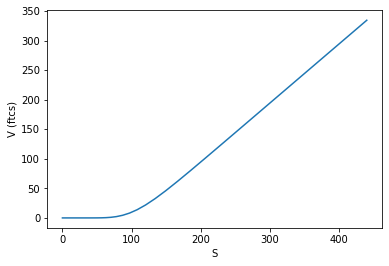

In [3]:
n_space = 100  # grid size
n_time = 1000  # time steps
r = 0.04
sigma = 0.3
strike_price = 110
stock_price = 100
S_max = 4 * strike_price
S_min = 0.01
t_max = 1

x_max = np.log(S_max)
x_min = np.log(S_min)
x0 = np.log(stock_price)

x, dx = np.linspace(x_min, x_max, n_space, retstep=True)  
t, dt = np.linspace(0, t_max, n_time, retstep=True)

s = np.exp(x)
payoff = np.maximum(s - strike_price, 0)
v = np.zeros((n_space, n_time))
v[:, -1] = payoff
v[0, :] = 0
v[-1, :] = np.exp(x_max) - strike_price * np.exp(-r * t[::-1])

sigma2, dx2 = sigma**2, dx**2

alpha = 0.5 * dt * ((0.5 * sigma2 - r) / dx + sigma2 / dx2)
beta = sigma2 * dt / dx2 + r * dt
gamma = 0.5 * dt * ((r - 0.5 * sigma2) / dx + sigma2 / dx2)

a = -alpha
b = 1 + beta
c = -gamma

A = diags([a, b, c], [-1, 0, 1], shape=(n_space-2, n_space-2)).tocsc()
offset = np.zeros(n_space-2)

for i in range(n_time-2, -1, -1):
    
    offset[0] = a * v[0,i]
    offset[-1] = c * v[-1,i]
    v[1:-1, i] = spsolve( A, (v[1:-1,i+1] - offset) )
    
v_ftcs = v[:,0]
print(f'call option value: {np.interp(x0, x, v_ftcs)}')

plt.plot(s, v_ftcs)
plt.xlabel('S')
plt.ylabel('V (ftcs)')
plt.show()

call option value: 9.774792497215705


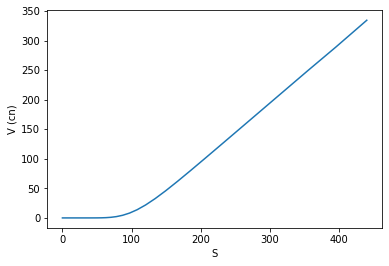

In [4]:
n_space = 100  # grid size
n_time = 1000  # time steps
r = 0.04
sigma = 0.3
strike_price = 110
stock_price = 100
S_max = 4 * strike_price
S_min = 0.01
t_max = 1

x_max = np.log(S_max)
x_min = np.log(S_min)
x0 = np.log(stock_price)

x, dx = np.linspace(x_min, x_max, n_space, retstep=True)  
t, dt = np.linspace(0, t_max, n_time, retstep=True)

s = np.exp(x)
payoff = np.maximum(s - strike_price, 0)
v = np.zeros((n_space, n_time))
v[:, -1] = payoff
v[0, :] = 0
for i in range(n_time-2, 0, -1):
    v[-1, i] = np.exp(x_max) - strike_price * np.exp(-r * (t_max - (i+1)*dt)) +\
               np.exp(x_max) - strike_price * np.exp(-r * (t_max - (i)*dt))
v[-1, 0] = np.exp(x_max) - strike_price * np.exp(-r)
v[-1, -1] = np.exp(x_max) - strike_price

sigma2, dx2 = sigma**2, dx**2

alpha = 0.25 * dt * ((0.5 * sigma2 - r) / dx + sigma2 / dx2)
beta = dt / 2 * (sigma2 / dx2 + r)
gamma = 0.25 * dt * ((r - 0.5 * sigma2) / dx + sigma2 / dx2)

a = -alpha
b1 = 1 + beta
b2 = 1 - beta
c = -gamma

A = diags([a, b1, c], [-1, 0, 1], shape=(n_space-2, n_space-2)).tocsc()
B = diags([-a, b2, -c], [-1, 0, 1], shape=(n_space-2, n_space-2)).tocsc()
offset = np.zeros(n_space-2)

for i in range(n_time-2, -1, -1):
    
    offset[0] = a * v[0,i]
    offset[-1] = c * v[-1,i]
    v[1:-1, i] = spsolve(A, B @ v[1:-1,i+1] - offset)
    
v_cn = v[:,0]
print(f'call option value: {np.interp(x0, x, v_cn)}')

plt.plot(s, v_cn)
plt.xlabel('S')
plt.ylabel('V (cn)')
plt.show()

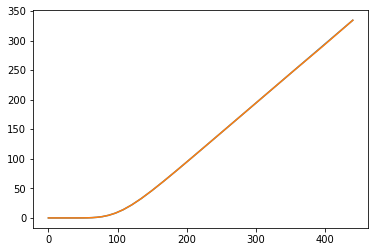

In [5]:
plt.plot(s, v_ftcs)
plt.plot(s, v_cn)
plt.show()